# Imports and setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from PIL import Image
import PIL.ImageOps
import os
import urllib.request
import zipfile


In [0]:
def preprocess_img(image_path):
    im = PIL.ImageOps.invert(Image.open(image_path).convert('L'))
    
    im = im.crop((5, 5, 76, 76))
    
    cutoff = 15
    
    pixels = im.load()
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            if pixels[i,j] < cutoff:
                pixels[i,j] = 0
            elif pixels[i,j] >= cutoff:
                pixels[i,j] = 255
    
    cropped_im = im.crop(im.getbbox())
    padded_im = pad_to_size(cropped_im, 71, 71)
    
    return np.asarray(padded_im)

    
def pad_to_size(im, new_w, new_h):
    new_im = Image.new("L", (new_w, new_h))
    new_im.paste(im, ((new_w - im.size[0])//2,
                      (new_h - im.size[1])//2))
    return new_im

# **TL;DR, Just give me a prediction!**

In [0]:
try:
    final_model = load_model('final_model.h5')
except:
    print("No model file found. Train the network once first, or upload your model as 'final_model.h5'")

def predict(image_path, verbose=False):
    img_arr = preprocess_img(image_path)
    img_arr = img_arr.reshape(1, img_arr.shape[0], img_arr.shape[1], 1).astype('float32')
    img_arr = img_arr / 255
    result = final_model.predict(img_arr)
    if verbose:
        print(result[0])
        
    return np.argmax(result)


In [127]:
print(predict('/0_blaa.bmp', True))


[[9.9999571e-01 2.5997146e-08 4.2681836e-06]]
0


# **I Have time, train the whole thing...**

Download dataset from Tola's github

In [0]:
local_zip_path = '/content/train.zip'
local_imgs_path = '/content/imgs/'

if not os.path.isfile(local_zip_path):
    urllib.request.urlretrieve('https://github.com/tolaw/dl-tutorial/raw/master/hebrew/train.zip', local_zip_path)
    
if not os.path.isdir(local_imgs_path):
    zip_ref = zipfile.ZipFile(local_zip_path, 'r')
    zip_ref.extractall(local_imgs_path)
    zip_ref.close()


Preprocess all the images

In [119]:
imgs = list()
labels = list()

for filename in os.listdir(local_imgs_path):
    if not filename.endswith('bmp'):
        continue
        
    img_arr = preprocess_img(os.path.join(local_imgs_path, filename))
    imgs.append(img_arr)
    labels.append(filename[0])
    
X = np.array(imgs)
y = np.array(labels)

img_dims = X[0].shape

print("Loaded {0} images ({1}x{2} pixels)".format(X.shape[0], X.shape[1], X.shape[2]))

Loaded 540 images (71x71 pixels)


Prepare training/testing sets

Training set:  {'0': 166, '1': 166, '2': 166}
Testing set:  {'0': 14, '1': 14, '2': 14}


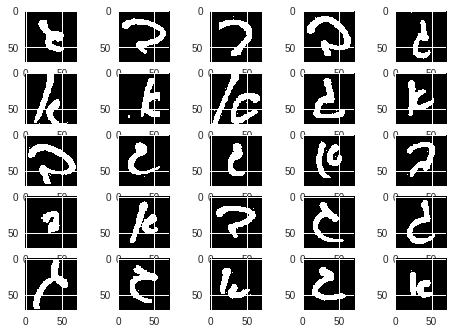

In [121]:
trainset_size = 498

X_train, y_train = X[:trainset_size], y[:trainset_size]
X_test, y_test = X[trainset_size:], y[trainset_size:]

unique, counts = np.unique(y_train, return_counts=True)
print("Training set: ", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("Testing set: ", dict(zip(unique, counts)))

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

# plot 4 images as gray scale
grid_size = 5
for i in range(grid_size**2):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

Format data for CNN

In [0]:
# CNN - prepare data

X_train_cnn = X_train.reshape(X_train.shape[0], img_dims[0],  img_dims[1], 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], img_dims[0], img_dims[1], 1).astype('float32')

# print(np.histogram(X_train[0]))

# normalize inputs from 0-255 to 0-1
X_train_cnn = X_train_cnn / 255
X_test_cnn = X_test_cnn / 255

X_for_plot = X_test_cnn

Build and train model

In [125]:
model = Sequential()

model.add(Conv2D(40, (10, 10), input_shape=(img_dims[0], img_dims[1], 1), activation='relu',kernel_initializer='normal'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(20, (3, 3), activation='relu', kernel_initializer='normal'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(60, activation='relu', kernel_initializer='normal'))

model.add(Dense(50, input_dim=img_dims[0] * img_dims[1], activation='relu', kernel_initializer='normal'))

model.add(Dense(num_classes, activation='softmax', kernel_initializer='normal'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

mcp_save = ModelCheckpoint('final_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train_cnn, y_train,
                    validation_data=(X_test_cnn, y_test),
                    epochs=20, batch_size=200, verbose=2,
                    callbacks=[mcp_save])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 40)        4040      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 31, 40)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 29, 29, 20)        7220      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 14, 14, 20)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 3920)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 60)                235260    
__________

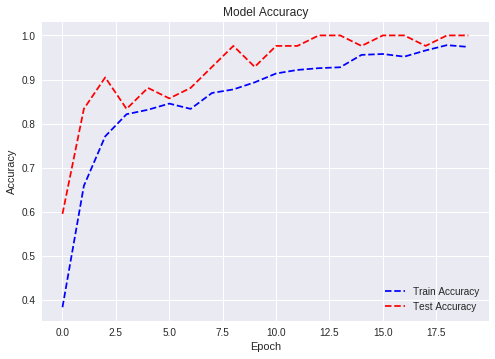

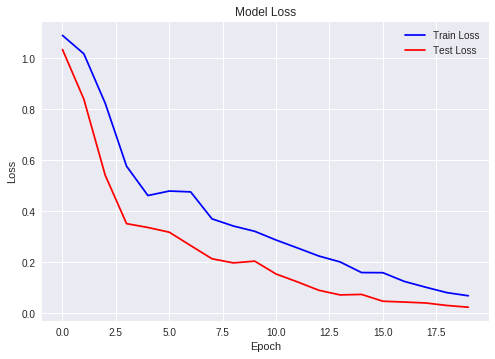

42/42 [==============================] - 0s 4ms/step
[0.023897333070635796, 1.0]


In [124]:
# Show training progress
plt.plot(history.history['acc'], 'b--')
plt.plot(history.history['val_acc'], 'r--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()
plt.plot(history.history['loss'], 'b-')
plt.plot(history.history['val_loss'], 'r-')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.show()

print(model.evaluate(x=X_for_plot, y=y_test, batch_size=200))

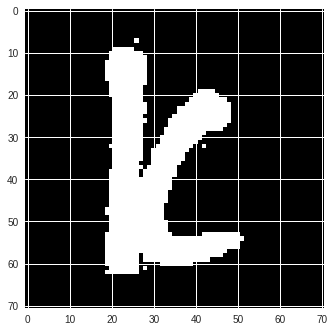

label: [1. 0. 0.]
prediction: [[9.6443099e-01 1.9330659e-05 3.5549752e-02]]


In [123]:
# Prediction
test_idx = 2

image = X_for_plot[test_idx]
image = image.reshape(img_dims[0], img_dims[1])
image = image * 255
image = image.astype(np.uint8)
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.show()

label = y_test[test_idx]
print(f"label: {label}")

prediction = model.predict(X_for_plot[test_idx:test_idx+1])
print(f"prediction: {prediction}")